## 必要なライブラリのインポート

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

In [2]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
import time

## ゲーム環境の作成と確認

In [3]:
env = gym.make('Breakout-v0')

In [4]:
env.frameskip = 4 # ゲーム環境で飛ばすフレーム数の指定
print('observation space:', env.observation_space) # 状態空間の確認
print('action space:', env.action_space) # ゲーム内で可能な行動選択の数

obs = env.reset() # ゲーム環境の初期化
obs = obs[:,:,0] # RGBのR要素のみを取り出し
obs = (misc.imresize(obs, (110, 84)))[110-84-8:110-8,:] # ゲームから取得した画面情報のリサイズ

observation space: Box(210, 160, 3)
action space: Discrete(4)


C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


1
reward: 0.0
done: False
info {'ale.lives': 5}


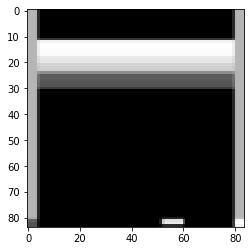

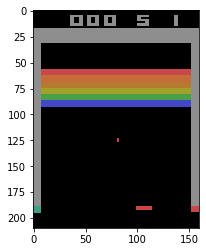

In [5]:
plt.imshow(obs, cmap='gray') # リサイズ後のゲーム画面の確認
action = env.action_space.sample() # ゲーム内での行動のサンプルをランダムに選択
print(action)
obs, r, done, info = env.step(action) # 行動を引数にstep関数を呼び出し、ゲームの状態をt+1の状態に遷移
# 戻り値に行動実行後のゲーム画面、報酬値、ゲームの終了判定、付加情報(学習には使用しない)。
plt.figure()
plt.imshow(obs)
print('reward:', r)
print('done:', done)
print('info', info)
# step関数の戻り値の確認

## Q関数の定義

In [6]:
class QFunction(chainer.Chain):
    
    def __init__(self, n_actions): # ネットワークの構造の定義
        super().__init__(
            L0=L.Convolution2D(4 , 32, ksize=8, stride=4),# 畳み込み層が3層
            L1=L.Convolution2D(32, 64, ksize=4, stride=2),
            L2=L.Convolution2D(64, 64, ksize=3, stride=1),
            L3=L.Linear(3136, 512),
            L4=L.Linear(512, n_actions)) # 出力の数は引数で渡された選択可能な行動の数
        
    def __call__(self, x, test=False):
        h = F.relu(self.L0(x))
        h = F.relu(self.L1(h))
        h = F.relu(self.L2(h))
        h = F.relu(self.L3(h))
        return chainerrl.action_value.DiscreteActionValue(self.L4(h))
    
n_actions = env.action_space.n # 選択可能な行動の数をn_actionsに代入
q_func = QFunction(n_actions) # q関数の初期化

## ネットワーク(Q関数)の最適化手法の選択

In [7]:
optimizer = chainer.optimizers.Adam(eps=1e-2) # 最適化手法にAdamを選択
optimizer.setup(q_func) # optimizerにQ関数をセット

## 各種パラメータの設定

In [8]:
gamma = 0.95 # 学習率

explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample, ) # 探索手法の選択(ε-greedy法)

replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 4) # replayBufferのサイズの設定(過去の1000経験を保持) 家のパソコンでメモリ使用量約1.6GB

phi = lambda x: x.astype(np.float32, copy=False) # np.float32形式ではないデータが発生したときにデータ形式を修正する関数

agent = chainerrl.agents.DQN(
        q_func, optimizer, replay_buffer, gamma, explorer,
        replay_start_size=500, update_interval=1,
        target_update_interval=100, phi=phi) # DQNのエージェントに各種パラメータを引数で渡して初期化

## 実際に学習を行う部分

In [9]:
agent.load('Breakout180') # 学習済みモデルの読み込み

n_episodes = 20 # 学習するゲーム数の設定
start = time.time() # 学習の開始時刻の記録
# n_episodes回学習を回す
for i in range(181, n_episodes + 181):
    obs4steps = np.zeros((4,84,84), dtype=np.float32)
    obs = env.reset()
    obs = obs[:,:,0]
    obs = (misc.imresize(obs, (110, 84)))[110-84-8:110-8,:]
    obs4steps[0] = obs # 4時刻分のゲーム画像に代入
    reward = 0 # 報酬値の初期化
    done = False # ゲームの終了判定の初期化
    R = 0 # 報酬値の合計の初期化
    t = 0 # ゲーム内時刻の初期化
    # ゲームが終了するまでループ
    while not done:
        action = agent.act_and_train(obs4steps, reward)
        obs, reward, done, _ = env.step(action)
        obs = obs[:,:,0]
        obs = (misc.imresize(obs, (110, 84)))[110-84-8:110-8,:]
        obs4steps = np.roll(obs4steps, 1, axis=0) # 4時刻分のゲーム画像を1時刻ずつずらす
        obs4steps[0] = obs # ずらした結果、一番古いゲーム画面が[0]に入っているので、新しいゲーム画面で上書き
        R += reward # 報酬値の合計を更新
        t += 1 # 時刻を更新
    # ゲーム数とスコア合計、経過時刻の確認
    print('episode:', i,
          'R:', R)
    print('time:', time.time() - start)
    agent.stop_episode_and_train(obs4steps, reward, done)
print('Finished')

C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\chainerrl\agent.py:26: UserWarning: KeyError('L0/W/t is not a file in the archive')
  warnings.warn(repr(e))
C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


episode: 181 R: 2.0
time: 1.3154826164245605
episode: 182 R: 3.0
time: 23.20751667022705
episode: 183 R: 2.0
time: 77.5974473953247
episode: 184 R: 2.0
time: 147.6998372077942
episode: 185 R: 6.0
time: 261.5396499633789
episode: 186 R: 1.0
time: 312.16890144348145
episode: 187 R: 3.0
time: 378.6099238395691
episode: 188 R: 2.0
time: 435.2944498062134
episode: 189 R: 3.0
time: 508.4560647010803
episode: 190 R: 1.0
time: 557.2726347446442
episode: 191 R: 4.0
time: 633.4199366569519
episode: 192 R: 2.0
time: 684.952573299408
episode: 193 R: 2.0
time: 738.3103792667389
episode: 194 R: 1.0
time: 780.6840057373047
episode: 195 R: 5.0
time: 869.3667087554932
episode: 196 R: 3.0
time: 927.4983131885529
episode: 197 R: 2.0
time: 982.9416975975037
episode: 198 R: 4.0
time: 1053.1555783748627
episode: 199 R: 3.0
time: 1112.608248949051
episode: 200 R: 3.0
time: 1187.765459060669
Finished


## 学習結果の保存

In [11]:
agent.save('Breakout200')

## 学習結果の読み出しと確認

### 学習開始直後の挙動確認

In [12]:
score50 = [0 for i in range(50)] # 報酬値の合計を保持する
agent.load('Breakout50')
for i in range(50):
    obs4steps = np.zeros((4,84,84))
    obs = env.reset()
    obs = obs[:,:,0]
    obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
    obs4steps[0] = obs
    done = False
    R = 0
    t = 0
    while not done:
        # env.render()のコメントを外す('ctrl'+'/')とテストプレイが別ウインドウで確認できる
#         env.render()
        action = agent.act(obs4steps)
        obs, r, done, _ = env.step(action)
        obs = obs[:,:,0]
        obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
        obs4steps = np.roll(obs4steps, 1, axis=0)
        obs4steps[0] = obs
        R += r
        t += 1
        # ボールを降らす操作が学習できていないとき段階で固まらないための対策
        if np.allclose(obs4steps[0], obs4steps[3]):
            env.step(1)
    
    score50[i] = R # 報酬値合計の記録
    print('test episode:', i, 'R:', R)

C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


test episode: 0 R: 0.0
test episode: 1 R: 0.0
test episode: 2 R: 3.0
test episode: 3 R: 0.0
test episode: 4 R: 1.0
test episode: 5 R: 1.0
test episode: 6 R: 0.0
test episode: 7 R: 0.0
test episode: 8 R: 0.0
test episode: 9 R: 0.0
test episode: 10 R: 1.0
test episode: 11 R: 1.0
test episode: 12 R: 2.0
test episode: 13 R: 0.0
test episode: 14 R: 0.0
test episode: 15 R: 0.0
test episode: 16 R: 0.0
test episode: 17 R: 1.0
test episode: 18 R: 0.0
test episode: 19 R: 0.0
test episode: 20 R: 0.0
test episode: 21 R: 0.0
test episode: 22 R: 1.0
test episode: 23 R: 1.0
test episode: 24 R: 1.0
test episode: 25 R: 0.0
test episode: 26 R: 0.0
test episode: 27 R: 0.0
test episode: 28 R: 0.0
test episode: 29 R: 0.0
test episode: 30 R: 0.0
test episode: 31 R: 0.0
test episode: 32 R: 1.0
test episode: 33 R: 2.0
test episode: 34 R: 0.0
test episode: 35 R: 0.0
test episode: 36 R: 0.0
test episode: 37 R: 0.0
test episode: 38 R: 1.0
test episode: 39 R: 2.0
test episode: 40 R: 1.0
test episode: 41 R: 5.0
te

In [13]:
print(np.mean(score50))

0.58


### 学習前モデルのスコア平均

In [14]:
score180 = [0 for i in range(50)]
agent.load('Breakout180')
for i in range(50):
    obs4steps = np.zeros((4,84,84))
    obs = env.reset()
    obs = obs[:,:,0]
    obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
    obs4steps[0] = obs
    done = False
    R = 0
    t = 0
    while not done:
#         env.render()
        action = agent.act(obs4steps)
        obs, r, done, _ = env.step(action)
        obs = obs[:,:,0]
        obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
        obs4steps = np.roll(obs4steps, 1, axis=0)
        obs4steps[0] = obs
        R += r
        t += 1
        if np.allclose(obs4steps[0], obs4steps[3]):
            env.step(1)
    
    score180[i] = R
    print('test episode:', i, 'R:', R)

C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


test episode: 0 R: 3.0
test episode: 1 R: 1.0
test episode: 2 R: 1.0
test episode: 3 R: 1.0
test episode: 4 R: 4.0
test episode: 5 R: 2.0
test episode: 6 R: 1.0
test episode: 7 R: 0.0
test episode: 8 R: 1.0
test episode: 9 R: 3.0
test episode: 10 R: 3.0
test episode: 11 R: 4.0
test episode: 12 R: 1.0
test episode: 13 R: 5.0
test episode: 14 R: 3.0
test episode: 15 R: 4.0
test episode: 16 R: 1.0
test episode: 17 R: 3.0
test episode: 18 R: 3.0
test episode: 19 R: 3.0
test episode: 20 R: 4.0
test episode: 21 R: 2.0
test episode: 22 R: 7.0
test episode: 23 R: 2.0
test episode: 24 R: 1.0
test episode: 25 R: 0.0
test episode: 26 R: 3.0
test episode: 27 R: 0.0
test episode: 28 R: 1.0
test episode: 29 R: 0.0
test episode: 30 R: 5.0
test episode: 31 R: 3.0
test episode: 32 R: 1.0
test episode: 33 R: 3.0
test episode: 34 R: 3.0
test episode: 35 R: 1.0
test episode: 36 R: 0.0
test episode: 37 R: 3.0
test episode: 38 R: 1.0
test episode: 39 R: 5.0
test episode: 40 R: 5.0
test episode: 41 R: 6.0
te

In [15]:
print(np.mean(score180))

2.52


In [16]:
score200 = [0 for i in range(50)]
agent.load('Breakout200')
for i in range(50):
    obs4steps = np.zeros((4,84,84))
    obs = env.reset()
    obs = obs[:,:,0]
    obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
    obs4steps[0] = obs
    done = False
    R = 0
    t = 0
    while not done:
#         env.render()
        action = agent.act(obs4steps)
        obs, r, done, _ = env.step(action)
        obs = obs[:,:,0]
        obs = (misc.imresize(obs, (110,84)))[110-84-8:110-8, :]
        obs4steps = np.roll(obs4steps, 1, axis=0)
        obs4steps[0] = obs
        R += r
        t += 1
        if np.allclose(obs4steps[0], obs4steps[3]):
            env.step(1)
    
    score200[i] = R
    print('test episode:', i, 'R:', R)

C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
C:\Users\haruk\Anaconda3\envs\ai-gpu\Lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


test episode: 0 R: 3.0
test episode: 1 R: 2.0
test episode: 2 R: 3.0
test episode: 3 R: 1.0
test episode: 4 R: 5.0
test episode: 5 R: 2.0
test episode: 6 R: 4.0
test episode: 7 R: 3.0
test episode: 8 R: 4.0
test episode: 9 R: 4.0
test episode: 10 R: 3.0
test episode: 11 R: 12.0
test episode: 12 R: 5.0
test episode: 13 R: 4.0
test episode: 14 R: 2.0
test episode: 15 R: 2.0
test episode: 16 R: 5.0
test episode: 17 R: 5.0
test episode: 18 R: 5.0
test episode: 19 R: 1.0
test episode: 20 R: 1.0
test episode: 21 R: 2.0
test episode: 22 R: 1.0
test episode: 23 R: 4.0
test episode: 24 R: 8.0
test episode: 25 R: 1.0
test episode: 26 R: 2.0
test episode: 27 R: 4.0
test episode: 28 R: 3.0
test episode: 29 R: 3.0
test episode: 30 R: 1.0
test episode: 31 R: 3.0
test episode: 32 R: 2.0
test episode: 33 R: 10.0
test episode: 34 R: 5.0
test episode: 35 R: 1.0
test episode: 36 R: 2.0
test episode: 37 R: 1.0
test episode: 38 R: 3.0
test episode: 39 R: 3.0
test episode: 40 R: 1.0
test episode: 41 R: 1.0


In [17]:
print(np.mean(score200))

3.16


reward: 0.0
done: True
info {'ale.lives': 0}


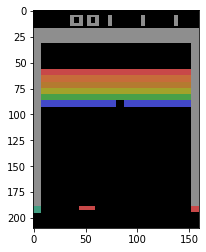

In [18]:
obs, r, done, info = env.step(action)
plt.figure()
plt.imshow(obs)
print('reward:', r)
print('done:', done)
print('info', info)